In [1]:
import pandas as pd
import os

In [2]:
s3_prefix = "s3://aegovan-data/pubmed_asbtract/predictions_largescale_ppimulticlass-bert-f1-2021-05-10-10_2021-07-01/"
s3_output_prefix = "{}_summary/".format(s3_prefix.rstrip("/"))
s3_data ="s3://aegovan-data/human_output/human_interactions_ppi_v2.json"

In [40]:
label_order = ["acetylation", "methylation", "phosphorylation", "dephosphorylation", "ubiquitination", "deubiquitination",  "other"]
pos_labels = list( filter(lambda x: x != 'other', label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {"other" : "Negative class"}

In [3]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [ ]:
!rm -rf $local_temp
!mkdir -p $local_temp_pred_dir
!mkdir -p $local_temp_wk_dir

In [4]:
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        


In [ ]:
%%time

download_files(s3_prefix, local_temp_pred_dir)

In [5]:
!ls -l $local_temp_dir | wc -l

      12


In [6]:
threshold_config = {'acetylation': {('confidence_std', 'count'): 5.0,
  ('confidence_std', 'mean'): 0.20221626758575403,
  ('confidence_std', 'std'): 0.010931891264366925,
  ('confidence_std', 'min'): 0.186287313699722,
  ('confidence_std', '25%'): 0.19900196790695102,
  ('confidence_std', '50%'): 0.20083150267601002,
  ('confidence_std', '75%'): 0.21166041493415802,
  ('confidence_std', 'max'): 0.21330013871192902,
  ('confidence', 'count'): 5.0,
  ('confidence', 'mean'): 0.5777932286262508,
  ('confidence', 'std'): 0.017217069729986746,
  ('confidence', 'min'): 0.555882334709167,
  ('confidence', '25%'): 0.572159707546234,
  ('confidence', '50%'): 0.57360166311264,
  ('confidence', '75%'): 0.5849224925041191,
  ('confidence', 'max'): 0.602399945259094},
 'dephosphorylation': {('confidence_std', 'count'): 29.0,
  ('confidence_std', 'mean'): 0.21133935400124204,
  ('confidence_std', 'std'): 0.07727310272430898,
  ('confidence_std', 'min'): 0.11373741179704601,
  ('confidence_std', '25%'): 0.141093701124191,
  ('confidence_std', '50%'): 0.18553803861141202,
  ('confidence_std', '75%'): 0.255215793848037,
  ('confidence_std', 'max'): 0.41554290056228604,
  ('confidence', 'count'): 29.0,
  ('confidence', 'mean'): 0.8063360175182077,
  ('confidence', 'std'): 0.13017405501056736,
  ('confidence', 'min'): 0.32787588238716103,
  ('confidence', '25%'): 0.7709274291992181,
  ('confidence', '50%'): 0.8457427024841301,
  ('confidence', '75%'): 0.8899683952331541,
  ('confidence', 'max'): 0.914224922657012},
 'deubiquitination': {('confidence_std', 'count'): 2.0,
  ('confidence_std', 'mean'): 0.1863851696252815,
  ('confidence_std', 'std'): 0.002637275825296506,
  ('confidence_std', 'min'): 0.184520334005355,
  ('confidence_std', '25%'): 0.18545275181531826,
  ('confidence_std', '50%'): 0.1863851696252815,
  ('confidence_std', '75%'): 0.18731758743524476,
  ('confidence_std', 'max'): 0.18825000524520802,
  ('confidence', 'count'): 2.0,
  ('confidence', 'mean'): 0.4542059451341625,
  ('confidence', 'std'): 0.010661192844799884,
  ('confidence', 'min'): 0.446667343378067,
  ('confidence', '25%'): 0.45043664425611474,
  ('confidence', '50%'): 0.4542059451341625,
  ('confidence', '75%'): 0.4579752460122103,
  ('confidence', 'max'): 0.461744546890258},
 'methylation': {('confidence_std', 'count'): 9.0,
  ('confidence_std', 'mean'): 0.20187029076947058,
  ('confidence_std', 'std'): 0.011129410572280824,
  ('confidence_std', 'min'): 0.185736715793609,
  ('confidence_std', '25%'): 0.19583970308303802,
  ('confidence_std', '50%'): 0.19923907518386802,
  ('confidence_std', '75%'): 0.210324048995971,
  ('confidence_std', 'max'): 0.21908366680145203,
  ('confidence', 'count'): 9.0,
  ('confidence', 'mean'): 0.7966000636418656,
  ('confidence', 'std'): 0.01647822043812186,
  ('confidence', 'min'): 0.7693868875503541,
  ('confidence', '25%'): 0.780769705772399,
  ('confidence', '50%'): 0.798503041267395,
  ('confidence', '75%'): 0.809625148773193,
  ('confidence', 'max'): 0.8169981241226191},
 'other': {('confidence_std', 'count'): 1116.0,
  ('confidence_std', 'mean'): 0.015799599189941234,
  ('confidence_std', 'std'): 0.0407698558038574,
  ('confidence_std', 'min'): 0.0008510624757030001,
  ('confidence_std', '25%'): 0.00117629769374575,
  ('confidence_std', '50%'): 0.0021780409151680004,
  ('confidence_std', '75%'): 0.007007123087532501,
  ('confidence_std', 'max'): 0.303181886672973,
  ('confidence', 'count'): 1116.0,
  ('confidence', 'mean'): 0.9903799230800303,
  ('confidence', 'std'): 0.026711376001797505,
  ('confidence', 'min'): 0.5133088827133171,
  ('confidence', '25%'): 0.9944566637277598,
  ('confidence', '50%'): 0.9974353015422815,
  ('confidence', '75%'): 0.998221039772033,
  ('confidence', 'max'): 0.9985265731811521},
 'phosphorylation': {('confidence_std', 'count'): 139.0,
  ('confidence_std', 'mean'): 0.09348429794416534,
  ('confidence_std', 'std'): 0.11442879568269237,
  ('confidence_std', 'min'): 0.006378921680152001,
  ('confidence_std', '25%'): 0.013172945939004001,
  ('confidence_std', '50%'): 0.034169171005487005,
  ('confidence_std', '75%'): 0.13673919439315751,
  ('confidence_std', 'max'): 0.469867438077926,
  ('confidence', 'count'): 139.0,
  ('confidence', 'mean'): 0.9306538756802781,
  ('confidence', 'std'): 0.09291076266425286,
  ('confidence', 'min'): 0.548133730888366,
  ('confidence', '25%'): 0.9297615289688106,
  ('confidence', '50%'): 0.9758448600769041,
  ('confidence', '75%'): 0.98560282588005,
  ('confidence', 'max'): 0.990909934043884},
 'ubiquitination': {('confidence_std', 'count'): 5.0,
  ('confidence_std', 'mean'): 0.1845212131738658,
  ('confidence_std', 'std'): 0.010037806334405529,
  ('confidence_std', 'min'): 0.174075484275817,
  ('confidence_std', '25%'): 0.177953422069549,
  ('confidence_std', '50%'): 0.18058878183364802,
  ('confidence_std', '75%'): 0.19217012822628002,
  ('confidence_std', 'max'): 0.197818249464035,
  ('confidence', 'count'): 5.0,
  ('confidence', 'mean'): 0.5571501374244686,
  ('confidence', 'std'): 0.07332355556921501,
  ('confidence', 'min'): 0.42922157049179005,
  ('confidence', '25%'): 0.5765218138694761,
  ('confidence', '50%'): 0.579930007457733,
  ('confidence', '75%'): 0.58320677280426,
  ('confidence', 'max'): 0.616870522499084}}

In [7]:
def get_summary_df(local_temp_pred_dir):
    list_df_high_quality = []
    list_df_summary = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )


        list_df_summary.append(df[["prediction", "confidence", "confidence_std"]])

        # Filter below threshold items
        high_quality_frames = []
        for k,t in threshold_config.items():
            conf_median = t[('confidence', '50%')]
            conf_std_median = t[('confidence_std', '50%')]
            high_quality_frames.append(df.query("prediction == '{}' and confidence >= {} and confidence_std <= {}"
                                                .format(k, conf_median, conf_std_median)))

        high_quality_df = pd.concat(high_quality_frames)

        list_df_high_quality.append(high_quality_df)

    
    return pd.concat(list_df_high_quality), pd.concat(list_df_summary)



In [8]:
%%time 


df_high_quality, df_summary = get_summary_df (local_temp_pred_dir)

CPU times: user 2min, sys: 5.87 s, total: 2min 6s
Wall time: 2min 8s


In [141]:
import matplotlib.gridspec as gridspec

import numpy as np

def box_plot_prediction_confidence(df, df_high_quality, subplot_spec, title_prefix="", set_title=True):
    interaction_types = label_order
    
    num_plots = len(interaction_types)
    gs = gridspec.GridSpecFromSubplotSpec(1, len(label_order), subplot_spec=subplot_spec)
    
    for i, interaction in enumerate(interaction_types):
        df_interaction = df.query(f"prediction == '{interaction}'")
        df_interaction_high_quality = df_high_quality.query(f"prediction == '{interaction}'")
        
        if len(df_interaction) == 0: continue
        
        ax = fig.add_subplot(gs[0, i])
    
    
        # Rename columns
        new_column_names = {"confidence":"c", 
                           "confidence_std" : "v"
                            }
        df_interaction = df_interaction.rename(columns = new_column_names)
        df_interaction_high_quality=df_interaction_high_quality.rename(columns = new_column_names)
        
        
        # Style and formatting..
        
        if set_title:
            ax.set_title("{}{}\nT={} (HQ={}%)".format( title_prefix,
                                               label_title_map.get(interaction, interaction).title(),
                                               len(df_interaction),
                                               round(100 * len(df_interaction_high_quality)/len(df_interaction),2)                
                                              )
                        )
        ax.set_ylim(0,1)
        
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        
        ax.spines['bottom'].set_color('grey')
        ax.spines['top'].set_color('grey') 
        ax.spines['right'].set_color('grey')
        ax.spines['left'].set_color('grey')
        
        
        # Plot violin plot        
        ax.violinplot(df_interaction[["c", "v" ]],  showmeans=True )
        if len(df_interaction_high_quality) > 0:
            ax.violinplot(df_interaction_high_quality[["c", "v" ]],  showmeans=True )
        
        
        x_labels = ['C', 'V']
        
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(x_labels) + 1))
        ax.set_xticklabels(x_labels)
        ax.set_xlim(0.25, len(x_labels) + 0.75)
        
        
       



        


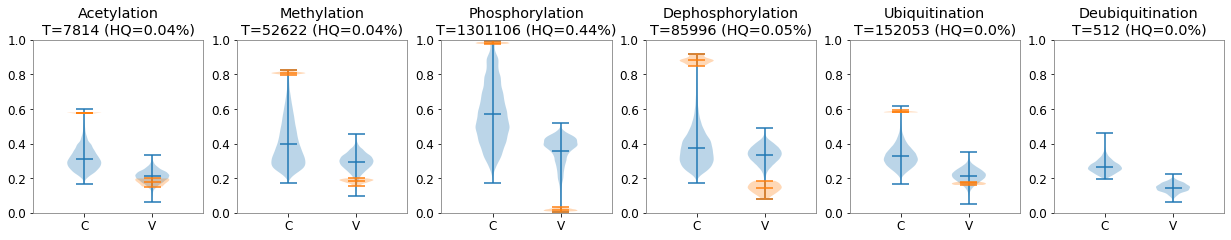

In [144]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_high_quality, gs[0])

plt.savefig("largescaleprediction_distribution.pdf", bbox_inches="tight")

In [145]:
df_summary.shape

(1600103, 3)

In [9]:
df_summary.groupby("prediction").describe().T

prediction            acetylation  dephosphorylation  deubiquitination  \
confidence     count  7814.000000       85996.000000        512.000000   
               mean      0.312708           0.377087          0.266125   
               std       0.063875           0.104960          0.035357   
               min       0.167926           0.172143          0.192550   
               25%       0.264918           0.299028          0.241865   
               50%       0.304162           0.362114          0.262090   
               75%       0.353461           0.433888          0.284913   
               max       0.600650           0.917424          0.461744   
confidence_std count  7814.000000       85996.000000        512.000000   
               mean      0.210510           0.336032          0.145046   
               std       0.036508           0.050607          0.025516   
               min       0.060708           0.082619          0.060518   
               25%       0.186282           0.302521          0.127965   
               50%       0.211377           0.338459          0.146132   
               75%       0.234980           0.372796          0.162277   
               max       0.334895           0.491449          0.224475   

prediction             methylation  phosphorylation  ubiquitination  
confidence     count  52622.000000     1.301106e+06   152053.000000  
               mean       0.396856     5.697892e-01        0.325775  
               std        0.127154     1.720569e-01        0.059669  
               min        0.171925     1.720937e-01        0.163623  
               25%        0.295094     4.383482e-01        0.282141  
               50%        0.368534     5.513105e-01        0.320400  
               75%        0.480175     6.917892e-01        0.363150  
               max        0.826972     9.907943e-01        0.614968  
confidence_std count  52622.000000     1.301106e+06   152053.000000  
               mean       0.294212     3.583199e-01        0.213993  
               std        0.048166     8.640525e-02        0.038750  
               min        0.095000     6.206166e-03        0.050221  
               25%        0.261997     3.160160e-01        0.187972  
               50%        0.295679     3.818166e-01        0.215154  
               75%        0.327972     4.198187e-01        0.241230  
               max        0.452854     5.203627e-01        0.350003

In [10]:
df_high_quality.groupby(["prediction"])[["prediction", "confidence", "confidence_std"]].describe().T

prediction            acetylation  dephosphorylation  methylation  \
confidence     count     3.000000          42.000000    23.000000   
               mean      0.577767           0.881514     0.809059   
               std       0.003032           0.019359     0.006814   
               min       0.574266           0.849926     0.799061   
               25%       0.576875           0.868206     0.805046   
               50%       0.579485           0.881211     0.807967   
               75%       0.579518           0.892138     0.811937   
               max       0.579551           0.917424     0.826972   
confidence_std count     3.000000          42.000000    23.000000   
               mean      0.180173           0.142870     0.183372   
               std       0.024727           0.028311     0.012262   
               min       0.152028           0.082619     0.154916   
               25%       0.171055           0.124469     0.176801   
               50%       0.190082           0.146389     0.186139   
               75%       0.194245           0.166641     0.191214   
               max       0.198408           0.184901     0.199017   

prediction            phosphorylation  ubiquitination  
confidence     count      5721.000000        5.000000  
               mean          0.982277        0.584419  
               std           0.003611        0.005255  
               min           0.975850        0.580424  
               25%           0.979242        0.580954  
               50%           0.982206        0.583207  
               75%           0.985243        0.584096  
               max           0.990794        0.593414  
confidence_std count      5721.000000        5.000000  
               mean          0.017550        0.169572  
               std           0.006499        0.007941  
               min           0.006206        0.160962  
               25%           0.012284        0.162796  
               50%           0.016811        0.170951  
               75%           0.022234        0.172560  
               max           0.034128        0.180589

In [146]:
df_high_quality.shape

(5794, 23)

In [11]:
download_file(s3_data, local_temp_wk_dir)

In [12]:
data_file = os.path.join(local_temp_wk_dir, s3_data.split("/")[-1])
data_training_full_df = pd.read_json(data_file)

In [13]:
data_training_full_df.shape

(3381, 7)

In [14]:
data_training_full_df.head(n=2)

,interactionId,interactionType,isNegative,participants,pubmedId,pubmedTitle,pubmedabstract
0,1585513,phosphorylation,false,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat...",17126281,None,Zipper-interacting protein kinase (ZIP kinase)...
1,1585516,phosphorylation,false,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-...",17126281,None,Zipper-interacting protein kinase (ZIP kinase)...


In [15]:
data_training_full_df["participants"].sample(n=2).iloc[0]

[{'uniprotid': 'P02718',
  'alias': [['achd_tetcf'],
   ['Acetylcholine receptor subunit delta'],
   ['chrnd']],
  'alternative_uniprots': []},
 {'uniprotid': 'Q96RG2',
  'alias': [['pask_human'],
   ['PAS domain-containing serine/threonine-protein kinase'],
   ['PASK'],
   ['KIAA0135']],
  'alternative_uniprots': ['G5E9F1',
   'Q9UFR7',
   'Q68DY3',
   'Q99763',
   'Q6GSJ5',
   'Q05BE4',
   'Q86XH6']}]

In [16]:
def get_partipants_key_raw(participants):
    """
    Example input
    [{'uniprotid': 'P19388',
  'alias': [['rpab1_human'],
   ['DNA-directed RNA polymerases I, II, and III subunit RPABC1'],
   ['POLR2E'],
   ['DNA-directed RNA polymerase II subunit E'],
   ['RPB5 homolog'],
   ['DNA-directed RNA polymerase II 23 kDa polypeptide'],
   ['XAP4']],
  'alternative_uniprots': ['Q6PIH5', 'Q9BT06', 'O43380', 'B2R6L4', 'D6W5Y1']},
 {'uniprotid': 'Q96SB4',
  'alias': [['srpk1_human'],
   ['SRSF protein kinase 1'],
   ['Serine/arginine-rich protein-specific kinase 1'],
   ['SFRS protein kinase 1'],
   ['SRPK1']],
  'alternative_uniprots': ['Q5R365', 'Q5R364', 'B4DS61', 'Q8IY12', 'Q12890']}]
    """
    participant_uniprot = []
    for p in participants:
        
        participant_uniprot.append(str(p["uniprotid"]))
        
        
    result = get_partipants_key(participant_uniprot)
    
    return result

def get_partipants_key(list_uniprot):
    participant_uniprot=sorted(filter (lambda x: x is not None, list_uniprot))
    
    result = "#".join(participant_uniprot)
    
    return result


def is_in_training(df, training_df):
    training_participants = training_df["participants"].apply(get_partipants_key_raw)
    df_particpiants = df[["participant2Id", "participant1Id"]].apply(lambda x : get_partipants_key([x["participant2Id"],x["participant2Id"]]), axis=1)
    return df_particpiants.isin(training_participants)

def is_in_training_pubmed(df, training_df):
    return df["pubmedId"].isin(training_df["pubmedId"])

In [17]:
df_high_quality["PubmedInTrainingData"] = is_in_training_pubmed( df_high_quality, data_training_full_df)

In [148]:
df_high_quality[~df_high_quality.PubmedInTrainingData].shape

(5676, 23)

In [18]:
c_df=pd.DataFrame(df_summary.query("prediction != 'other'")\
                  .groupby([ "prediction"]).size()).rename(columns={0: "all_count"})
tmp_df = pd.DataFrame(df_high_quality[~df_high_quality.PubmedInTrainingData]\
      .groupby('prediction').size())\
      .rename(columns={0: "filter_count"})

tmp_df = tmp_df.merge(c_df, left_index=True,  right_index=True, how="right")\
      [[ "all_count", "filter_count"]]

print(tmp_df.to_latex( index=True))

tmp_df

\begin{tabular}{lrr}
\toprule
{} &  all\_count &  filter\_count \\
prediction        &            &               \\
\midrule
acetylation       &       7814 &           1.0 \\
dephosphorylation &      85996 &          29.0 \\
deubiquitination  &        512 &           NaN \\
methylation       &      52622 &          19.0 \\
phosphorylation   &    1301106 &        5623.0 \\
ubiquitination    &     152053 &           4.0 \\
\bottomrule
\end{tabular}



,all_count,filter_count
prediction,,
acetylation,7814,1.0
dephosphorylation,85996,29.0
deubiquitination,512,NaN
methylation,52622,19.0
phosphorylation,1301106,5623.0
ubiquitination,152053,4.0


In [19]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [20]:
df_high_quality.sample(n=10)

,pubmedId,participant1Id,participant1Name,participant2Id,participant2Name,abstract,normalised_abstract,annotations,gene_to_uniprot_map,normalised_abstract_annotations,other,phosphorylation,dephosphorylation,methylation,ubiquitination,acetylation,deubiquitination,prediction,confidence,confidence_std,raw_confidence,PubmedInTrainingData
1771,10713178,P19838,NF-kappaB,Q16584,mixed-lineage group kinase 3,The phosphorylation of IkappaB by the multipro...,The phosphorylation of IkappaB by the multipro...,"[{'start': '128', 'end': '137', 'name': 'NF-ka...","{'4790': 'P19838', '4296': 'Q16584', '65268': ...","[{'charOffset': 128, 'len': 6, 'text': 'P19838...",0.005584,0.988489,0.001695,0.001126,0.001090,0.001124,0.000893,phosphorylation,0.988489,0.010427,"[0.9938772320747371, 0.965550124645233, 0.9954...",False
1119,10739259,P05114,HMG-14,P05204,HMG-17,High mobility group (HMG) proteins 14 and 17 a...,High mobility group (HMG) proteins 14 and 17 a...,"[{'start': '206', 'end': '212', 'name': 'HMG-1...","{'3150': 'P05114', '3151': 'P05204'}","[{'charOffset': 206, 'len': 6, 'text': 'P05114...",0.002964,0.982603,0.005299,0.003325,0.002063,0.001850,0.001894,phosphorylation,0.982603,0.012510,"[0.9926366806030271, 0.965641856193542, 0.9834...",False
814,28223426,P12931,Src,Q05397,FAK,Trastuzumab in combination with chemotherapy i...,Trastuzumab in combination with chemotherapy i...,"[{'start': '73', 'end': '81', 'name': 'patient...","{'2064': 'P04626', '6714': 'P12931', '5747': '...","[{'charOffset': 93, 'len': 6, 'text': 'P04626'...",0.004614,0.986170,0.001929,0.002020,0.001991,0.001469,0.001807,phosphorylation,0.986170,0.009145,"[0.978983461856842, 0.9773170351982111, 0.9823...",False
209,30429409,O00418,eEF2K,P13639,Eukaryotic elongation factor 2,Eukaryotic elongation factor 2 (eEF2) kinase (...,P13639 (P13639) kinase (O00418) inhibits prote...,"[{'start': '0', 'end': '30', 'name': 'Eukaryot...","{'1938': 'P13639', '29904': 'O00418'}","[{'charOffset': 0, 'len': 6, 'text': 'P13639'}...",0.008722,0.982915,0.001683,0.002238,0.001418,0.001376,0.001649,phosphorylation,0.982915,0.019205,"[0.933307409286499, 0.9770186543464661, 0.9927...",False
1412,7852364,P78356,PtdIns(4)P 5-kinase,Q9Y2I7,Fab1p,"Phosphatidylinositol 4,5-bisphosphate (PtdIns(...","Phosphatidylinositol 4,5-bisphosphate (PtdIns(...","[{'start': '326', 'end': '345', 'name': 'PtdIn...","{'8396': 'P78356', '200576': 'Q9Y2I7', '8395':...","[{'charOffset': 326, 'len': 6, 'text': 'P78356...",0.003999,0.986728,0.001868,0.002577,0.001690,0.001612,0.001526,phosphorylation,0.986728,0.013556,"[0.9955505132675171, 0.9682319760322571, 0.995...",False
812,9581644,P01100,c-fos,P16220,cAMP response element-binding protein,This study examined influences of ethanol expo...,This study examined influences of ethanol expo...,"[{'start': '73', 'end': '110', 'name': 'cAMP r...","{'1385': 'P16220', '1051': 'P17676', '2353': '...","[{'charOffset': 73, 'len': 6, 'text': 'P16220'...",0.004947,0.979940,0.003891,0.002804,0.003566,0.002187,0.002664,phosphorylation,0.979940,0.023303,"[0.993565618991851, 0.9707393050193781, 0.9950...",False
686,21982595,P16333,Nck,P19525,PKR,dsRNA-activated protein kinase (PKR) is activa...,dsRNA-activated protein kinase (P19525) is act...,"[{'start': '32', 'end': '35', 'name': 'PKR', '...","{'5610': 'P19525', '1965': 'P05198', '4690': '...","[{'charOffset': 32, 'len': 6, 'text': 'P19525'...",0.010207,0.980283,0.002084,0.001952,0.002099,0.001435,0.001939,phosphorylation,0.980283,0.017104,"[0.9740351438522331, 0.973725914955139, 0.9942...",False
989,7753855,P27694,HSSB,P51946,p34,The trimeric human single-stranded DNA-binding...,The trimeric human single-stranded DNA-binding...,"[{'start': '13', 'end': '18', 'name': 'human',...","{'6117': 'P27694', '902': 'P51946', '890': 'P2...","[{'charOffset': 56, 'len': 6, 'text': 'P27694'...",0.009386,0.976533,0.002324,0.002754,0.003975,0.002643,0.002385,phosphorylation,0.976533,0.030880,"[0.9912335276603691, 0.9760165810585021, 0.966...",Fa

In [21]:
df_high_quality["unique_gene_count"] = df_high_quality["gene_to_uniprot_map"].apply(lambda x: len(x))

In [22]:
df_high_quality.groupby("prediction")[["confidence","unique_gene_count"]].describe()

confidence                                          \
                       count      mean       std       min       25%   
prediction                                                             
acetylation              3.0  0.577767  0.003032  0.574266  0.576875   
dephosphorylation       42.0  0.881514  0.019359  0.849926  0.868206   
methylation             23.0  0.809059  0.006814  0.799061  0.805046   
phosphorylation       5721.0  0.982277  0.003611  0.975850  0.979242   
ubiquitination           5.0  0.584419  0.005255  0.580424  0.580954   

                                                unique_gene_count            \
                        50%       75%       max             count      mean   
prediction                                                                    
acetylation        0.579485  0.579518  0.579551               3.0  4.333333   
dephosphorylation  0.881211  0.892138  0.917424              42.0  3.380952   
methylation        0.807967  0.811937  0.826972              23.0  2.304348   
phosphorylation    0.982206  0.985243  0.990794            5721.0  3.081804   
ubiquitination     0.583207  0.584096  0.593414               5.0  2.600000   

                                                       
                        std  min  25%  50%  75%   max  
prediction                                             
acetylation        1.527525  3.0  3.5  4.0  5.0   6.0  
dephosphorylation  1.342593  2.0  3.0  3.0  4.0   7.0  
methylation        0.470472  2.0  2.0  2.0  3.0   3.0  
phosphorylation    1.307570  2.0  2.0  3.0  4.0  11.0  
ubiquitination     0.547723  2.0  2.0  3.0  3.0   3.0

In [23]:
predictions_above_threshold_file = "predictions_above_threshold.json"
df_high_quality.to_json(predictions_above_threshold_file, orient='records')

In [24]:
upload_file(predictions_above_threshold_file, "{}/".format(s3_output_prefix.rstrip("/")))

In [25]:
samples_per_interaction = 30

samples_subset = df_high_quality.query("PubmedInTrainingData == False")\
                .groupby('prediction', group_keys=False)\
                .apply(lambda x: x.sample(min(len(x), samples_per_interaction),random_state=45))

samples_subset.groupby(["prediction"])["prediction"].count()

prediction
acetylation           1
dephosphorylation    29
methylation          19
phosphorylation      30
ubiquitination        4
Name: prediction, dtype: int64

In [26]:
samples_subset.columns

Index(['pubmedId', 'participant1Id', 'participant1Name', 'participant2Id',
       'participant2Name', 'abstract', 'normalised_abstract', 'annotations',
       'gene_to_uniprot_map', 'normalised_abstract_annotations', 'other',
       'phosphorylation', 'dephosphorylation', 'methylation', 'ubiquitination',
       'acetylation', 'deubiquitination', 'prediction', 'confidence',
       'confidence_std', 'raw_confidence', 'PubmedInTrainingData',
       'unique_gene_count'],
      dtype='object')

### Create ground truth training jobs

In [27]:
import json
import json
def create_manifest_file(df, outfile):
    items = df.to_dict(orient='records' )
    with open(outfile , "w") as f:
        for item in items:
            # Write without new lines
            item_m  = {}
            item_m["source"] = json.dumps(item)
            f.write(json.dumps(item_m).replace("\n", "\t"))
            f.write("\n")

In [28]:
def create_manifest_per_interaction(samples_subset_df, s3_output_prefix):
    samples_subset_file = "predictions_sample_subset.json"
    samples_subset_df.to_json(samples_subset_file, orient='records')
    upload_file(samples_subset_file, "{}/".format(s3_output_prefix.rstrip("/")))


    manifest_file = "predictions_sample_subset.mainfest"
    create_manifest_file(samples_subset_df, manifest_file)
    upload_file(manifest_file, "{}/".format(s3_output_prefix.rstrip("/")))

    # Create one manifest file per interaction type
    m_files=[]
    for i in list(samples_subset_df["prediction"].unique()):
        manifest_file = "predictions_sample_subset_{}.mainfest".format(i)
        s3_manifest_file = "{}/{}".format(s3_output_prefix.rstrip("/"), manifest_file)
        create_manifest_file(samples_subset_df.query("prediction == '{}'".format(i)), manifest_file)
        upload_file(manifest_file, s3_manifest_file)
        
        m_files.append(s3_manifest_file)
    return m_files


In [29]:
s3_manifests = create_manifest_per_interaction(samples_subset, s3_output_prefix)

In [30]:
import boto3
import sagemaker

In [31]:
from datetime import datetime

def create_groundtruth_labelling_job(s3_manifest, s3_gt_output, s3_template, pre_lambda, post_lambda, role, workforce_name, job_name, label_attribute_name="prediction", workforce_type= "private-crowd" ):
    client = boto3.client('sagemaker')
    
    sagemaker_session = sagemaker.Session()
    account_id =  boto3.client('sts').get_caller_identity().get('Account')
    region = boto3.session.Session().region_name
    
    workforce_arn = "arn:aws:sagemaker:{}:{}:workteam/{}/{}".format(region, account_id, workforce_type, workforce_name)
    role_arn = "arn:aws:iam::{}:role/{}".format( account_id,  role)
    pre_lambda_arn = "arn:aws:lambda:{}:{}:function:{}".format(region, account_id,  pre_lambda)
    post_lambda_arn = "arn:aws:lambda:{}:{}:function:{}".format(region, account_id,  post_lambda)
    
    num_workers_per_object = 1
    task_time_limit_sec = 60  * 60 * 5
    task_availablity_sec =60  * 60 * 24 * 10
    
    job = client.create_labeling_job(LabelingJobName=job_name
                                    ,LabelAttributeName = label_attribute_name
                                    ,InputConfig = {
                                        "DataSource": {
                                            'S3DataSource': {
                                            'ManifestS3Uri': s3_manifest
                                            }
                                        }
                                        
                                    }
                                  ,OutputConfig={
                                        'S3OutputPath': s3_gt_output
                                    }

                                  , RoleArn = role_arn
                                  , HumanTaskConfig={
                                    'WorkteamArn': workforce_arn,
                                    'UiConfig': {
                                        'UiTemplateS3Uri': s3_template
                                    },
                                    'PreHumanTaskLambdaArn': pre_lambda_arn,
                                    'TaskKeywords': [
                                        'PPI',
                                    ],
                                    'TaskTitle': 'Verify PPI extraction for protein {}'.format(s3_manifest.split("/")[-1]),
                                    'TaskDescription': 'Verifies PPi extraction',
                                    'NumberOfHumanWorkersPerDataObject': num_workers_per_object,
                                    'TaskTimeLimitInSeconds': task_time_limit_sec,
                                    'TaskAvailabilityLifetimeInSeconds': task_availablity_sec,
                                    'MaxConcurrentTaskCount': 10,
                                    'AnnotationConsolidationConfig': {
                                        'AnnotationConsolidationLambdaArn': post_lambda_arn
                                    }
                                }
                            )
    
    return job
    
    

def create_groundtruth_labelling_multiple_jobs(lst_s3_manifests, s3_gt_output, s3_template, pre_lambda, post_lambda, role, workforce_name, job_prefix ="ppi", label_attribute_name="class"):
    job_prefix = "{}-{}".format(job_prefix , datetime.now().strftime("%Y%m%d%H%M%S"))
    for s3_manifest in lst_s3_manifests:
        job_name = "{}-{}".format( job_prefix, s3_manifest.split("/")[-1].split("_")[-1].split(".")[0])
        print(f"Creating job {job_name}")
        create_groundtruth_labelling_job(s3_manifest, s3_gt_output, s3_template, pre_lambda, post_lambda, role, workforce_name, job_name)

In [32]:
import urllib.request

def download_template(template_url):
    with urllib.request.urlopen(template_url) as f:
        html = f.read().decode('utf-8')

    with open("template.html", "w") as f:
        f.write(html)
    
download_template('http://raw.githubusercontent.com/elangovana/ppi-sagemaker-groundtruth-verification/main/src/template/template.html')

In [33]:
role_name = "service-role/AmazonSageMaker-ExecutionRole-20210104T161547"
pre_lambda="Sagemaker-ppipreprocessing"
post_lambda="sagemaker-ppipostprocessing"
s3_gt_output = "{}/gt_output/".format(s3_prefix.rstrip("/"))
workforce_name = "ppi-team"
s3_template_file = "{}/template.html".format(s3_prefix.rstrip("/"))

upload_file("template.html", s3_template_file )
create_groundtruth_labelling_multiple_jobs (s3_manifests,
                                            s3_gt_output, 
                                            s3_template_file,
                                            pre_lambda, 
                                            post_lambda, 
                                            role_name,
                                            workforce_name)

Creating job ppi-20210619153907-acetylation
Creating job ppi-20210619153907-dephosphorylation
Creating job ppi-20210619153907-methylation
Creating job ppi-20210619153907-phosphorylation
Creating job ppi-20210619153907-ubiquitination


## Verify the ground truth jobs

In [149]:
ground_truth_jobs = [
"ppi-20210619153907-ubiquitination",
"ppi-20210619153907-phosphorylation",
"ppi-20210619153907-methylation",
"ppi-20210619153907-dephosphorylation",
"ppi-20210619153907-acetylation"
]

In [150]:
import pandas, json,   ast


def load_manifest_file(manifest_file):
    with open(manifest_file) as f:
        df_list = []
        for l in  f.readlines():
            record = json.loads(l)
            result = json.loads(record["source"])
            meta_key = list([k for k,_ in  record.items() if k.endswith( "-metadata" )])[0]
            result ["human_result"] = record[meta_key.replace("-metadata","")]["result"]
            
            df_list.append(result)
        return df_list
    
def load_manifests(manifest_files):
    l = []
    if isinstance (manifest_files, str): manifest_files=[manifest_files]
    for f in manifest_files:
        l.extend(load_manifest_file(f))
        
    return pd.DataFrame(l)
    
def load_manifests_s3(s3_manifest_files, local_dir):
    l = []
    if isinstance (s3_manifest_files, str): manifest_files=[s3_manifest_files]
    for s3_file in s3_manifest_files:
        manifest_file=os.path.join(local_dir , s3_file.split("/")[-1] )
        download_file(s3_file, local_dir)
        l.extend(load_manifest_file(manifest_file))
        
    return pd.DataFrame(l)

In [ ]:
s3_gt_output_mainifests = ["{}/{}/manifests/output/output.manifest".format(s3_gt_output.rstrip("/"),j) for j in ground_truth_jobs]
df = load_manifests_s3(s3_gt_output_mainifests,local_temp)

In [172]:
df_gt_summary = df.groupby(["prediction", "human_result"])["human_result"].count().unstack().fillna(0).T
df_gt_summary["total"] = df_gt_summary.sum(axis=1)
df_gt_summary.loc["total"]= df_gt_summary.sum(axis=0)

In [173]:
df_gt_summary

prediction,acetylation,dephosphorylation,methylation,phosphorylation,ubiquitination,total
human_result,,,,,,
Correct,0.0,11.0,11.0,6.0,0.0,28.0
Incorrect - DNA Methylation,0.0,0.0,2.0,0.0,0.0,2.0
Incorrect - NER,0.0,2.0,1.0,3.0,0.0,6.0
Incorrect - No trigger word,0.0,1.0,0.0,2.0,4.0,7.0
Incorrect - Opposite type,0.0,1.0,0.0,0.0,0.0,1.0
Incorrect - relationship not described,0.0,14.0,4.0,19.0,0.0,37.0
Not - sure,1.0,0.0,1.0,0.0,0.0,2.0
total,1.0,29.0,19.0,30.0,4.0,83.0
